In [24]:
import pandas as pd
import numpy as np
from squad_df import v2
from collections import Counter, defaultdict
from blingfire import text_to_words
from tqdm import tqdm_notebook
from itertools import permutations


def build(df):

    df = df[['question', 'context']]

    passages = list(set(df.context.values))
    ptoi = {p: i for i, p in enumerate(passages)}
    itop = {i: p for p, i in ptoi.items()}

    dataset = []
    for _, row in df.iterrows():
        dataset.append((row.question, ptoi[row.context], row.context))
    return  pd.DataFrame(dataset, columns=['question', 'ctxid', 'relevant']), ptoi, itop, passages

df = pd.DataFrame(list(v2))
df = df.loc[df.is_train]
df = df.sample(df.shape[0])

df = df.reset_index()
df = df[:1000]
all_letters = [letter for letter, count in Counter(''.join(df.context).lower()).items() if count > 1000]

In [25]:
class CharIdf:
    def __init__(self, ngrams=3):
        self.ngrams = ngrams
        global all_letters
        self.grams = []
        for i in range(1, ngrams+1):
            self.grams += [''.join(i) for i in permutations(all_letters, i)]
        self.gram_length = len(self.grams)
        self.gram_to_index = {gram: index for index, gram in enumerate(self.grams)}
    
    def _make_grams(self, word):
        word = list(word)
        for i in range(len(word)):
            for j in range(i, i + self.ngrams):
                yield ''.join(word[i: j+1])
            
    
    def __getitem__(self, word, cache={}):
        if word not in cache:
            vec = np.zeros(self.gram_length)
            for gram in self._make_grams(word):
                if gram in self.gram_to_index:
                    vec[self.gram_to_index[gram]] += 1
            cache[word] = vec
        return cache[word]
    
    def fit(self, docs):
        self.idf = defaultdict(int)
        for doc in docs:
            for word in set(text_to_words(doc)):
                self.idf[word] += 1

    def transform(self, docs):
        docvecs = np.zeros((len(docs), self.gram_length))
        print('making vectors')
        for index, doc in enumerate(tqdm_notebook(docs)):
            for word, count in Counter(text_to_words(doc)).items():
                v = (self[word] * count) / (1 + self.idf[word])
                docvecs[index] += v
        return docvecs
    
    def fit_transform(self, docs):
        self.fit(docs)
        return self.transform(docs)

vec = CharIdf()

In [26]:
docs = list(set(df.context))
x = vec.fit_transform(docs)
qv = vec.transform(df.question)

making vectors



making vectors


In [27]:
x.shape, qv.shape

((980, 44136), (1000, 44136))

In [28]:
result = np.einsum('kd,md->km', x, qv)

In [29]:
result.shape

(980, 1000)

In [31]:
!pipenv install seaborn

Installing seaborn...
  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/69/f5e05f578585ed9935247be3788b374f90701296a70c8871bcd6d21edb00/matplotlib-3.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl

Adding seaborn to Pipfile's [packages]...
Pipfile.lock (6100c2) out of date, updating to (9bc113)...
Locking [dev-packages] dependencies...
Locking [packages] depen

In [32]:
import seaborn as sns

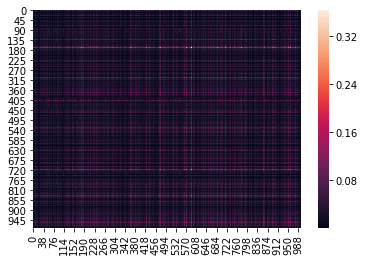

In [33]:
sns.heatmap(result)